In [ ]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import joblib # type: ignore

import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

from sklearn.preprocessing import StandardScaler # type: ignore
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectFromModel # type: ignore
from sklearn.linear_model import LogisticRegression # type: ignore
from sklearn.pipeline import Pipeline # type: ignore
from sklearn.model_selection import GridSearchCV, train_test_split # type: ignore
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score # type: ignore
from imblearn.over_sampling import SMOTE # type: ignore
from sklearn.compose import ColumnTransformer # type: ignore
from sklearn.ensemble import ExtraTreesClassifier # type: ignore
from sklearn.svm import SVC # type: ignore
from sklearn.ensemble import RandomForestClassifier # type: ignore
from sklearn.utils.class_weight import compute_class_weight # type: ignore
from sklearn.neural_network import MLPClassifier # type: ignore
from sklearn.model_selection import GridSearchCV # type: ignore
from sklearn.neighbors import KNeighborsClassifier # type: ignore
from sklearn.inspection import permutation_importance # type: ignore

from xgboost import XGBClassifier # type: ignore



In [ ]:
x_train = pd.read_csv('x_train_openSmile_emobase.csv')
y_train = pd.read_csv('y_train_openSmile_emobase.csv')
x_test = pd.read_csv('x_test_openSmile_emobase.csv')
y_test = pd.read_csv('y_test_openSmile_emobase.csv')

y_test['emotion'] = np.where(y_test['emotion'] == 'happy', 1, 0)
y_train['emotion'] = np.where(y_train['emotion'] == 'happy', 1, 0)


In [26]:
print(y_train['emotion'].value_counts())
print(y_test['emotion'].value_counts())

emotion
0    1077
1     216
Name: count, dtype: int64
emotion
0    530
1    107
Name: count, dtype: int64


In [22]:
etc = ExtraTreesClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
).fit(x_train, y_train["emotion"])

selector = SelectFromModel(etc, threshold="mean", prefit=True)

# 5) Grab the feature names
selected_features = x_train.columns[selector.get_support()]
print(f"Kept {len(selected_features)} features:")
print(selected_features.tolist())

print(f"Filtered down to {len(selected_features)} features.")
print(selected_features[:5])

Kept 389 features:
['pcm_intensity_sma_minPos', 'pcm_loudness_sma_max', 'pcm_loudness_sma_linregerrA', 'pcm_loudness_sma_skewness', 'pcm_loudness_sma_quartile3', 'pcm_loudness_sma_iqr2-3', 'mfcc_sma[1]_min', 'mfcc_sma[1]_range', 'mfcc_sma[1]_maxPos', 'mfcc_sma[1]_linregc1', 'mfcc_sma[1]_linregerrA', 'mfcc_sma[1]_linregerrQ', 'mfcc_sma[1]_stddev', 'mfcc_sma[1]_kurtosis', 'mfcc_sma[1]_iqr2-3', 'mfcc_sma[2]_max', 'mfcc_sma[2]_min', 'mfcc_sma[2]_maxPos', 'mfcc_sma[2]_minPos', 'mfcc_sma[2]_amean', 'mfcc_sma[2]_linregc1', 'mfcc_sma[2]_linregerrA', 'mfcc_sma[2]_linregerrQ', 'mfcc_sma[2]_stddev', 'mfcc_sma[2]_skewness', 'mfcc_sma[2]_kurtosis', 'mfcc_sma[2]_quartile1', 'mfcc_sma[2]_quartile2', 'mfcc_sma[2]_quartile3', 'mfcc_sma[2]_iqr1-2', 'mfcc_sma[2]_iqr2-3', 'mfcc_sma[2]_iqr1-3', 'mfcc_sma[3]_min', 'mfcc_sma[3]_linregerrA', 'mfcc_sma[3]_linregerrQ', 'mfcc_sma[3]_stddev', 'mfcc_sma[3]_skewness', 'mfcc_sma[3]_quartile1', 'mfcc_sma[3]_quartile2', 'mfcc_sma[3]_quartile3', 'mfcc_sma[3]_iqr1-3', '

988


C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


=== Happy Binary Classification Report ===
              precision    recall  f1-score   support

   not happy       0.90      0.45      0.60       530
       happy       0.22      0.77      0.34       107

    accuracy                           0.50       637
   macro avg       0.56      0.61      0.47       637
weighted avg       0.79      0.50      0.56       637



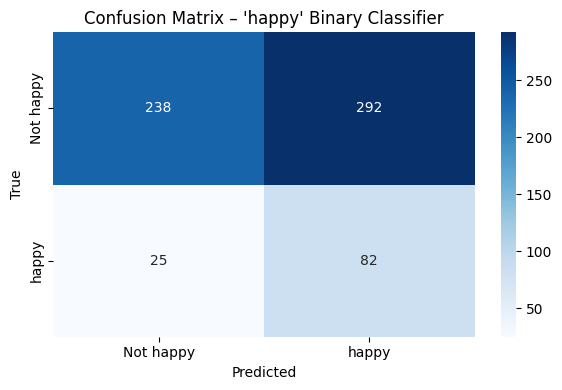

In [27]:
selector = ColumnTransformer(
  [
    ("pick_happy", "passthrough", selected_features)
  ],
  remainder="drop"
)

test = print(x_train.shape[1])

mlp = MLPClassifier(
  hidden_layer_sizes=(128, 64),
  activation="relu",
  alpha=1e-3,
  learning_rate_init=1e-3,
  solver="adam",
  max_iter=1000,
  random_state=42,
  verbose=False
)

svc = SVC(
  kernel="rbf",
  class_weight="balanced",
  probability=True,
  random_state=42
)

happy_pipe = Pipeline([
    ("select", selector),
    ("test", test),
    ("clf", svc)
])

happy_pipe.fit(x_train, y_train)

y_pred = happy_pipe.predict(x_test)
print("=== Happy Binary Classification Report ===")
print(classification_report(y_test, y_pred, target_names=["not happy","happy"]))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=[f"Not {"happy"}", "happy"],
    yticklabels=[f"Not {"happy"}", "happy"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix – '{"happy"}' Binary Classifier")
plt.tight_layout()
plt.show()


In [ ]:
x_test_sel = x_test[selected_features]

result = permutation_importance(
    happy_pipe, 
    x_test_sel, 
    y_test, 
    scoring="f1", 
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

importances = result.importances_mean

idxs      = np.argsort(importances)[::-1]
top_n     = 150
top_idxs  = idxs[:top_n]
top_feats = [selected_features[i] for i in top_idxs]

In [ ]:
print("Top {top_n} features by permutation importance:")
print(top_feats)

Top {top_n} features by permutation importance:
['F0env_sma_de_skewness', 'mfcc_sma[12]_iqr2-3', 'voiceProb_sma_de_maxPos', 'mfcc_sma_de[9]_min', 'lspFreq_sma_de[3]_maxPos', 'F0env_sma_de_kurtosis', 'mfcc_sma[5]_iqr2-3', 'lspFreq_sma_de[4]_max', 'lspFreq_sma_de[2]_min', 'lspFreq_sma[2]_iqr1-3', 'mfcc_sma[11]_range', 'lspFreq_sma_de[3]_quartile1', 'mfcc_sma[11]_linregerrQ', 'mfcc_sma_de[10]_range', 'pcm_zcr_sma_quartile2', 'mfcc_sma[12]_iqr1-3', 'lspFreq_sma[7]_minPos', 'mfcc_sma[10]_iqr2-3', 'pcm_zcr_sma_iqr1-2', 'mfcc_sma_de[1]_maxPos', 'lspFreq_sma_de[3]_skewness', 'mfcc_sma_de[12]_maxPos', 'mfcc_sma_de[6]_quartile3', 'lspFreq_sma[4]_iqr1-2', 'mfcc_sma[11]_stddev', 'mfcc_sma[7]_min', 'lspFreq_sma_de[2]_kurtosis', 'mfcc_sma[11]_skewness', 'mfcc_sma[11]_amean', 'mfcc_sma_de[6]_linregerrQ', 'mfcc_sma_de[6]_iqr1-3', 'mfcc_sma_de[6]_quartile1', 'mfcc_sma[7]_max', 'mfcc_sma[11]_linregerrA', 'lspFreq_sma_de[4]_range', 'lspFreq_sma_de[1]_linregc1', 'mfcc_sma[8]_amean', 'lspFreq_sma_de[0]_qua

C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


=== Happy Binary Classification Report ===
              precision    recall  f1-score   support

   not happy       0.91      0.78      0.84       530
       happy       0.36      0.61      0.45       107

    accuracy                           0.75       637
   macro avg       0.63      0.69      0.65       637
weighted avg       0.82      0.75      0.77       637



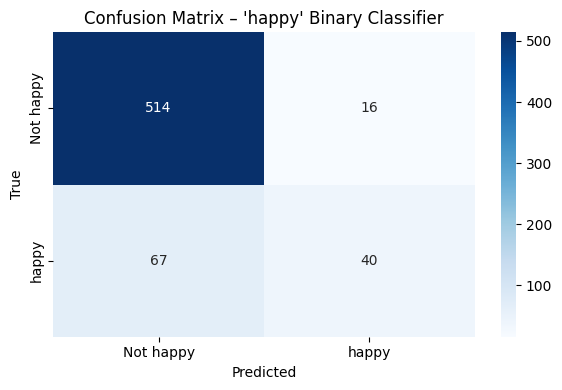

In [ ]:
selector2 = ColumnTransformer(
  [
    ("pick_happy", "passthrough", top_feats)
  ],
  remainder="drop"
)

happy_pipe2 = Pipeline([
    ("select", selector2),
    ("clf", LogisticRegression(
        penalty="l1",
        solver="saga",
        C=1.0,
        class_weight="balanced",
        max_iter=5000,
        random_state=42
      ))
])

happy_pipe2.fit(x_train, y_train)

y_pred2 = happy_pipe2.predict(x_test)
print("=== Happy Binary Classification Report ===")
print(classification_report(y_test, y_pred2, target_names=["not happy","happy"]))

cm2 = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm2, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=[f"Not {"happy"}", "happy"],
    yticklabels=[f"Not {"happy"}", "happy"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix – '{"happy"}' Binary Classifier")
plt.tight_layout()
plt.show()


In [ ]:
# ("clf", XGBClassifier(
#         use_label_encoder=False,
#         eval_metric="logloss",
#         scale_pos_weight=(y_train==0).sum()/(y_train==1).sum()
#     ))
# ("clf", MLPClassifier(
#         hidden_layer_sizes=(128, 64),
#         activation="relu",
#         alpha=1e-3,
#         learning_rate_init=1e-3,
#         solver="adam",
#         max_iter=1000,
#         random_state=42,
#         verbose=False
#     ))
# ("clf", LogisticRegression(
#         penalty="l1",
#         solver="saga",
#         C=1.0,
#         class_weight="balanced",
#         max_iter=5000,
#         random_state=42
#     ))
# ("clf", SVC(
#         kernel="linear",
#         class_weight="balanced",
#         random_state=42
#     ))
# ("clf", RandomForestClassifier(
#         n_estimators=100,
#         max_depth=10,
#         class_weight="balanced",
#         random_state=42
#     ))
# ("clf", KNeighborsClassifier(
#         n_neighbors=5,
#         weights="distance",
#         metric="euclidean",
#         n_jobs=-1
#     ))
# ("clf", ExtraTreesClassifier(
#         n_estimators=100,
#         max_depth=10,
#         class_weight="balanced",
#         random_state=42
#     ))
